# Machine Learning Assignment 1

This ipython notebook is work of **Adheesh Trivedi**.

## Loading the dataset

We will use numpy's `loadtxt` function to load the dataset given in CSV format.

In [1]:
import numpy as np

data = np.loadtxt('training_data.csv', delimiter=',', skiprows=1)

UNLABELED_DATA = np.loadtxt('test_data.csv', delimiter=',', skiprows=1)

In [2]:
# Some constants the will be used throughout the notebook

CLS1 = 1
CLS2 = 2

X, y = data[:, :2], data[:, 2]
data_cls_1 = data[data[:, 2] == CLS1]
data_cls_2 = data[data[:, 2] == CLS2]

## Plotting the dataset

We will use matplotlib's `pyplot` submodule to plot the data.

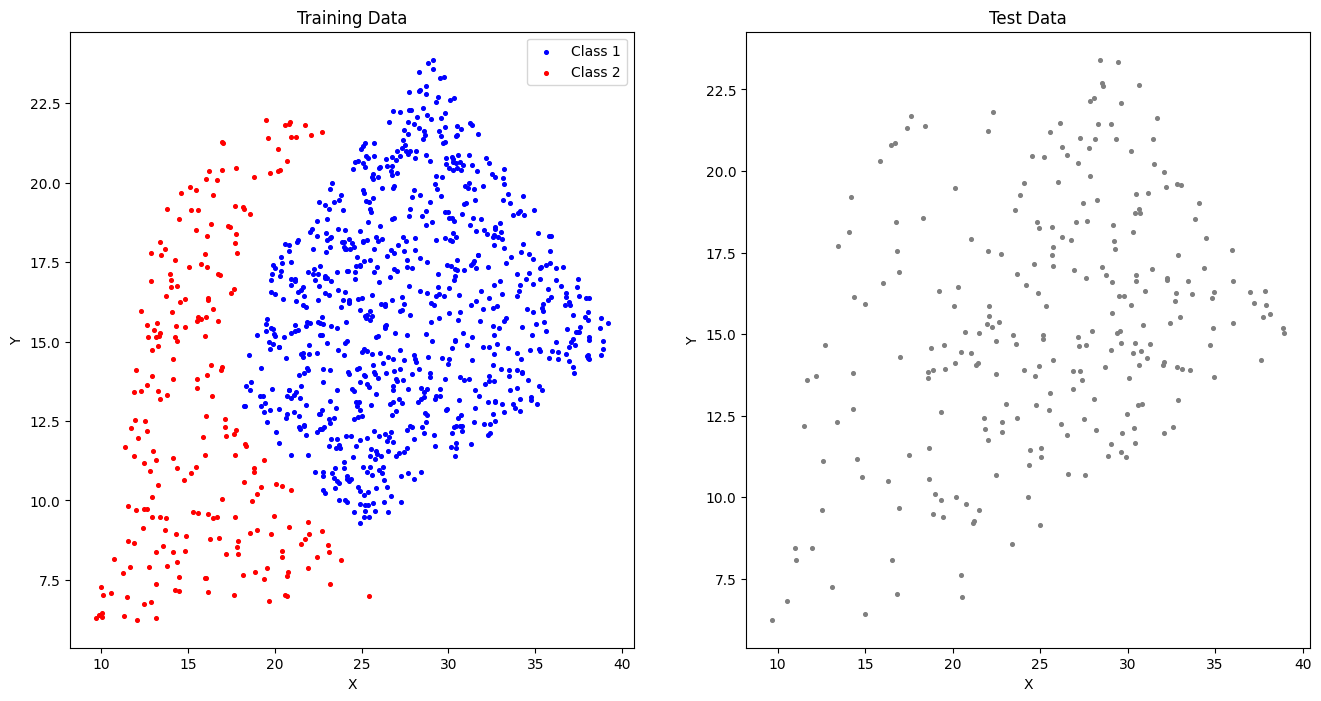

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, num=1, figsize=(16, 8))

axs[0].scatter(data_cls_1[:, 0], data_cls_1[:, 1], s=7., c='b', label = 'Class 1')
axs[0].scatter(data_cls_2[:, 0], data_cls_2[:, 1], s=7., c='r', label = 'Class 2')
axs[0].set_title('Training Data')
axs[0].set_xlabel('X'); axs[0].set_ylabel('Y')
axs[0].legend()

axs[1].scatter(UNLABELED_DATA[:, 0], UNLABELED_DATA[:, 1], s=7., c='grey')
axs[1].set_title('Test Data')
axs[1].set_xlabel('X'); axs[1].set_ylabel('Y')

plt.show()

## K-Folding in the dataset

I am going to use Stratified K folding in the given dataset to generate training and testing samples. K-Folds implemented in exact way discussed in class!

In [4]:
rng = np.random

# A constant seed for reproducibility
RS = 32
rng.seed(RS)

K = 8 # num folds

ratio = len(data_cls_1) / len(data_cls_2)

choices_cls_1 = rng.choice(len(data_cls_1), len(data_cls_1), replace=False)
choices_cls_2 = rng.choice(len(data_cls_2), len(data_cls_2), replace=False)

folds = []

for i in range(K):
    fold = np.concatenate((
        data_cls_1[choices_cls_1[i::K]],
        data_cls_2[choices_cls_2[i::K]],
    ))
    rng.shuffle(fold)
    folds.append(fold)

    print(f'Fold {i+1:2d} has {len(fold)} samples with {len(choices_cls_1[i::K])} and {len(choices_cls_2[i::K])} samples from class 1 and 2 respectively.')


Fold  1 has 129 samples with 100 and 29 samples from class 1 and 2 respectively.
Fold  2 has 129 samples with 100 and 29 samples from class 1 and 2 respectively.
Fold  3 has 129 samples with 100 and 29 samples from class 1 and 2 respectively.
Fold  4 has 129 samples with 100 and 29 samples from class 1 and 2 respectively.
Fold  5 has 129 samples with 100 and 29 samples from class 1 and 2 respectively.
Fold  6 has 128 samples with 100 and 28 samples from class 1 and 2 respectively.
Fold  7 has 128 samples with 100 and 28 samples from class 1 and 2 respectively.
Fold  8 has 127 samples with 99 and 28 samples from class 1 and 2 respectively.


In [5]:
from typing import Generator


def train_and_test_split(_folds : list[np.ndarray], k : int) \
    -> Generator[tuple, None, None]:
    '''
    Make the `test` fold the test set and the rest the training set.
    Returns tuple of traning and test sets in following format:
    X_train, y_train, X_test, y_test
    '''

    for i in range(k):
        test = _folds[i]
        train = np.concatenate(_folds[:i] + _folds[i+1:])

        yield train[:, :2], train[:, 2], test[:, :2], test[:, 2]

## Decision Trees

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

best_acc = 0
best_dtc = None

for i, (X_train, y_train, X_test, y_test) in enumerate(train_and_test_split(folds, K)):

    dtc = DecisionTreeClassifier(random_state=22016)

    dtc.fit(X_train, y_train)

    acc = dtc.score(X_test, y_test)

    if acc > best_acc:
        best_acc = acc
        best_dtc = dtc

    print(f'Accuracy for fold {i+1:2d} is {acc:.3f}')

Accuracy for fold  1 is 0.992
Accuracy for fold  2 is 1.000
Accuracy for fold  3 is 0.984
Accuracy for fold  4 is 0.992
Accuracy for fold  5 is 0.984
Accuracy for fold  6 is 0.992
Accuracy for fold  7 is 1.000
Accuracy for fold  8 is 1.000


Displaying the best decision tree classifier.

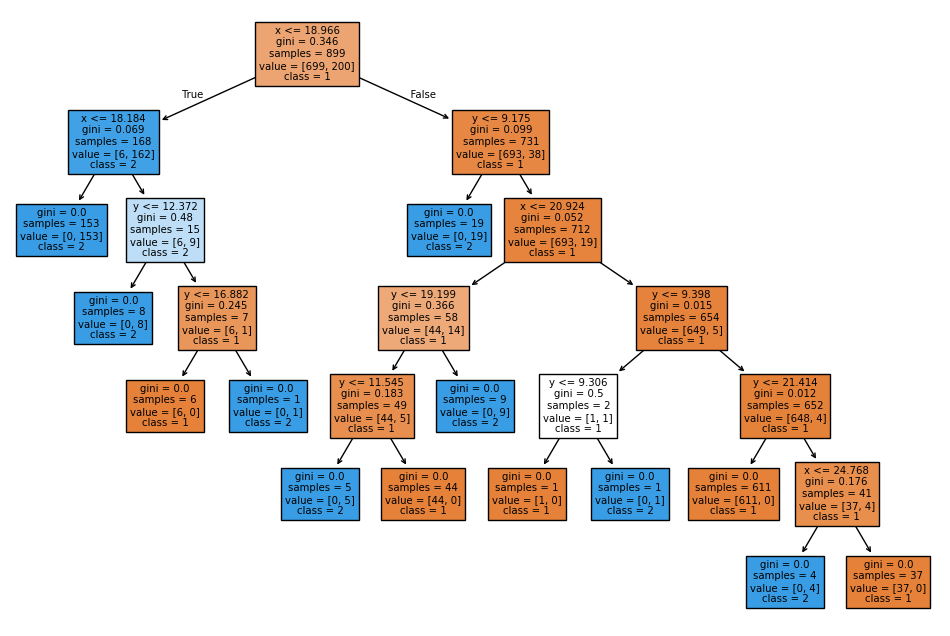

In [7]:
if best_dtc is not None:
    plt.figure(num=2, figsize=(12, 8))
    plot_tree(best_dtc, filled=True, feature_names=('x', 'y'), class_names=('1', '2'))
else:
    print('No Decision Tree with accuracy >0.')

Using `GridSearchCV` to optimize the parameters and passing `cv` parameter to perform k-folding.

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd

cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=RS)

param_grid = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'splitter' : ['best', 'random'],
    'max_depth' : range(6, 11, 2)
}

dtc_gscv = GridSearchCV(
    DecisionTreeClassifier(random_state=RS),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1
)

dtc_gscv.fit(X, y)

cols = [f'param_{p}' for p in param_grid]
cols.extend(
    ['mean_score_time', 'mean_test_score', 'rank_test_score']
)

pd.DataFrame(dtc_gscv.cv_results_)[
    cols
].sort_values('rank_test_score')

,param_criterion,param_splitter,param_max_depth,mean_score_time,mean_test_score,rank_test_score
5,gini,random,10,0.000000,0.994171,1
17,log_loss,random,10,0.001000,0.994163,2
11,entropy,random,10,0.002000,0.994163,2
3,gini,random,8,0.002000,0.993194,4
15,log_loss,random,8,0.001000,0.993187,5
9,entropy,random,8,0.000000,0.993187,5
0,gini,best,6,0.002923,0.992203,7
4,gini,best,10,0.001000,0.992203,7
2,gini,best,8,0.000378,0.992203,7
16,log_loss,best,10,0.001000,0.990272,10


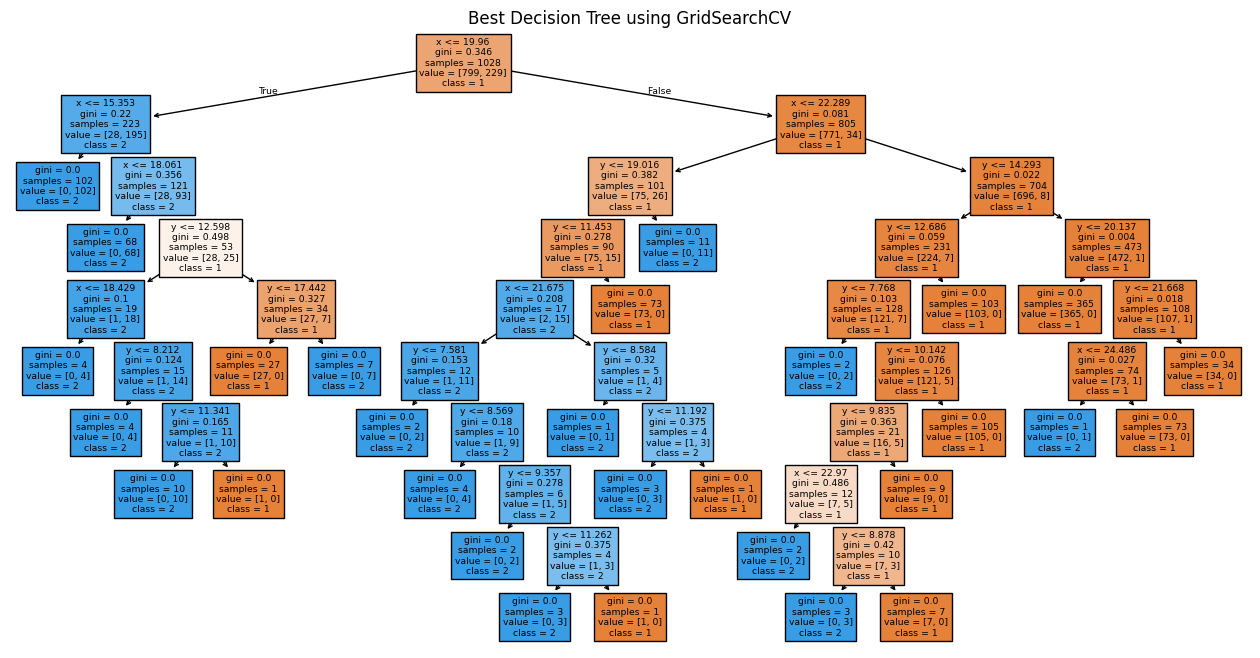

In [9]:
plt.figure(num=3, figsize=(16, 8))

plot_tree(dtc_gscv.best_estimator_, filled=True, feature_names=('x', 'y'), class_names=('1', '2'))

plt.title('Best Decision Tree using GridSearchCV')

plt.show()

Now we visualize the best decision tree thus found.

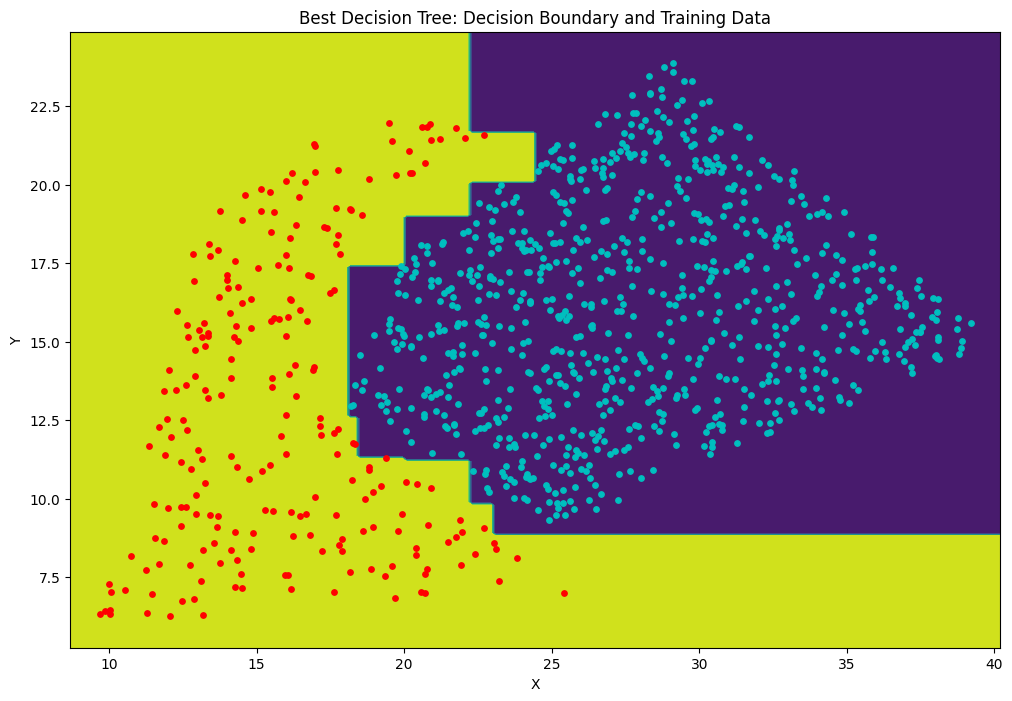

In [10]:
from sklearn.inspection import DecisionBoundaryDisplay

plt.figure(num=4, figsize=(12, 8))

dtc_display = DecisionBoundaryDisplay.from_estimator(
    dtc_gscv.best_estimator_, X,
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Best Decision Tree: Decision Boundary and Training Data')
plt.xlabel('X'); plt.ylabel('Y')

plt.scatter(data_cls_1[:, 0], data_cls_1[:, 1], s=15., c='c', label = 'Class 1')
plt.scatter(data_cls_2[:, 0], data_cls_2[:, 1], s=15., c='r', label = 'Class 2')

plt.show()

Note the boundary is very blocky and looks like is composed of hard squares (which it is). Also the decision boundary is very close to the training points at some places, which is not good, the point just after that boundary is classified as other class while having neighboring of other class.

## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators" : range(3, 11, 1),
    'max_depth' : range(6, 11, 2)
}

rfc_gscv = GridSearchCV(
    RandomForestClassifier(
        criterion=dtc_gscv.best_params_['criterion'],
        random_state=RS
    ),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1
)

rfc_gscv.fit(X, y)

cols = [f'param_{p}' for p in param_grid]
cols.extend(
    ['mean_score_time', 'mean_test_score', 'rank_test_score']
)

pd.DataFrame(rfc_gscv.cv_results_)[
    cols
].sort_values('rank_test_score').head(10)

,param_n_estimators,param_max_depth,mean_score_time,mean_test_score,rank_test_score
20,7,10,0.000,0.992203,1
22,9,10,0.003,0.992195,2
11,6,8,0.000,0.991226,3
18,5,10,0.003,0.991226,3
14,9,8,0.001,0.991226,3
12,7,8,0.003,0.991226,3
9,4,8,0.002,0.991226,3
15,10,8,0.001,0.991219,8
23,10,10,0.002,0.991219,8
7,10,6,0.002,0.990257,10


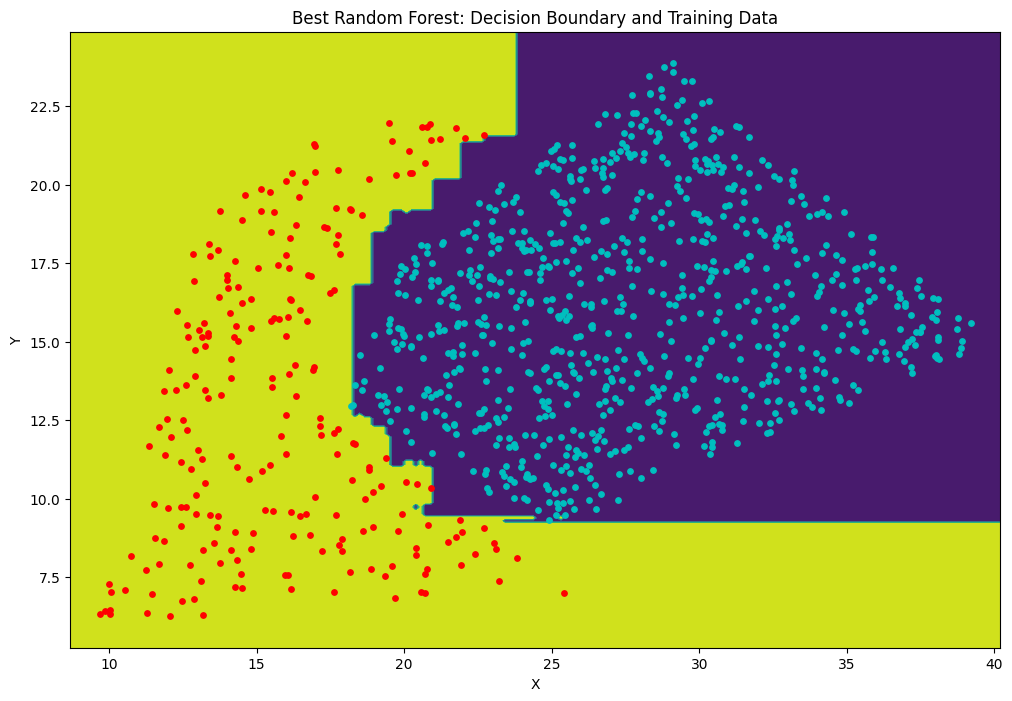

In [12]:
plt.figure(num=5, figsize=(12, 8))

rfc_display = DecisionBoundaryDisplay.from_estimator(
    rfc_gscv.best_estimator_, X, response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Best Random Forest: Decision Boundary and Training Data')
plt.xlabel('X'); plt.ylabel('Y')

plt.scatter(data_cls_1[:, 0], data_cls_1[:, 1], s=15., c='c', label = 'Class 1')
plt.scatter(data_cls_2[:, 0], data_cls_2[:, 1], s=15., c='r', label = 'Class 2')

plt.show()

## k-Nearest Neighbours

In [13]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors' : range(4, 11, 1),
    'weights' : ('distance', 'uniform'),
    'p' : (2, 3)
}

knc_gscv = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1
)

knc_gscv.fit(X, y)

cols = [f'param_{p}' for p in param_grid]
cols.extend(
    ['mean_score_time', 'mean_test_score', 'rank_test_score']
)

pd.DataFrame(knc_gscv.cv_results_)[
    cols
].sort_values('rank_test_score').head(10)

,param_n_neighbors,param_weights,param_p,mean_score_time,mean_test_score,rank_test_score
0,4,distance,2,0.003008,1.0,1
15,7,uniform,3,0.010903,1.0,1
14,7,distance,3,0.004000,1.0,1
11,6,uniform,3,0.011001,1.0,1
10,6,distance,3,0.001000,1.0,1
8,6,distance,2,0.002000,1.0,1
7,5,uniform,3,0.011997,1.0,1
18,8,distance,3,0.003000,1.0,1
5,5,uniform,2,0.014997,1.0,1
4,5,distance,2,0.004000,1.0,1


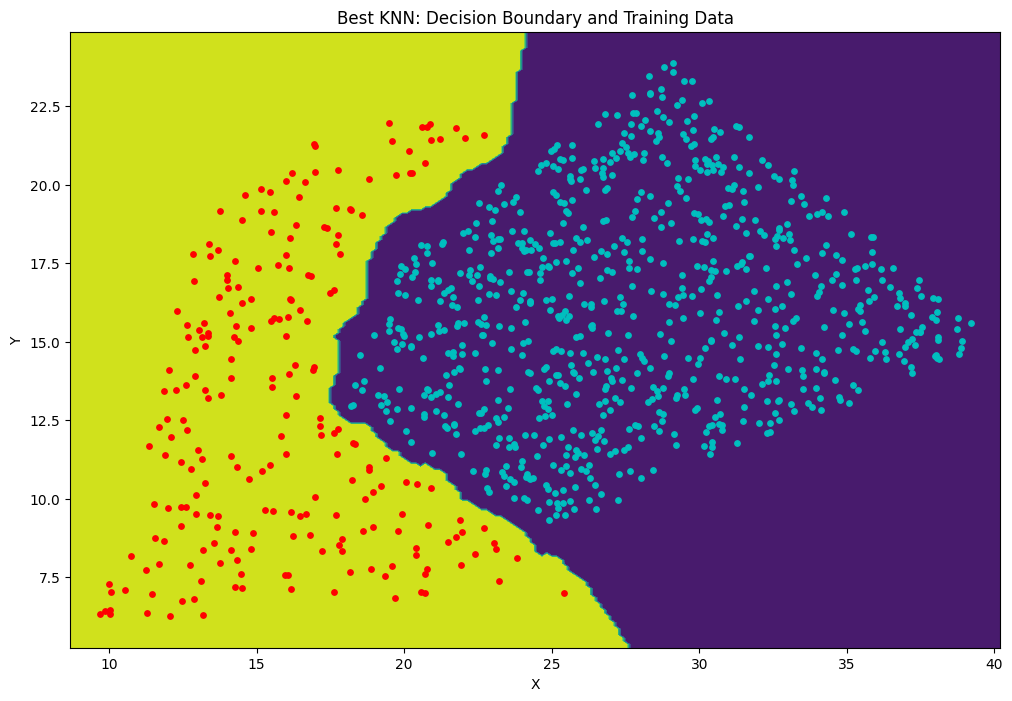

In [14]:
plt.figure(num=6, figsize=(12, 8))

knc_display = DecisionBoundaryDisplay.from_estimator(
    knc_gscv.best_estimator_, X, response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Best KNN: Decision Boundary and Training Data')
plt.xlabel('X'); plt.ylabel('Y')

plt.scatter(data_cls_1[:, 0], data_cls_1[:, 1], s=15., c='c', label = 'Class 1')
plt.scatter(data_cls_2[:, 0], data_cls_2[:, 1], s=15., c='r', label = 'Class 2')

plt.show()

## Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=RS)

lr.fit(X, y)

LogisticRegression(random_state=32)

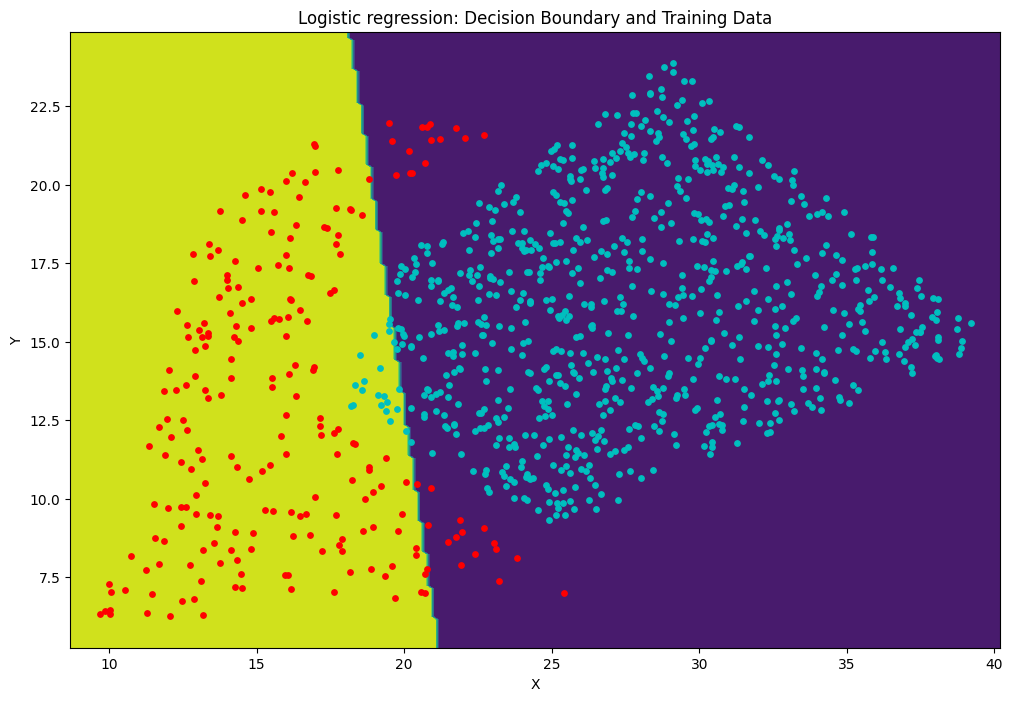

In [16]:
plt.figure(num=7, figsize=(12, 8))

lr_display = DecisionBoundaryDisplay.from_estimator(
    lr, X, response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Logistic regression: Decision Boundary and Training Data')
plt.xlabel('X'); plt.ylabel('Y')

plt.scatter(data_cls_1[:, 0], data_cls_1[:, 1], s=15., c='c', label = 'Class 1')
plt.scatter(data_cls_2[:, 0], data_cls_2[:, 1], s=15., c='r', label = 'Class 2')

plt.show()

As you can see the main problem arrises with this model is that it is linear but the boundary on other classifier is not linear, and it shouldn't be.

In [17]:
param_grid = {
    'penalty' : ['l2', None],
}

lr_gscv = GridSearchCV(
    LogisticRegression(random_state=RS),
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1
)

lr_gscv.fit(X, y)

cols = [f'param_{p}' for p in param_grid]
cols.extend(
    ['mean_score_time', 'mean_test_score', 'rank_test_score']
)

pd.DataFrame(lr_gscv.cv_results_)[
    cols
].sort_values('rank_test_score')

,param_penalty,mean_score_time,mean_test_score,rank_test_score
0,l2,0.000,0.949423,1
1,None,0.001,0.949423,1


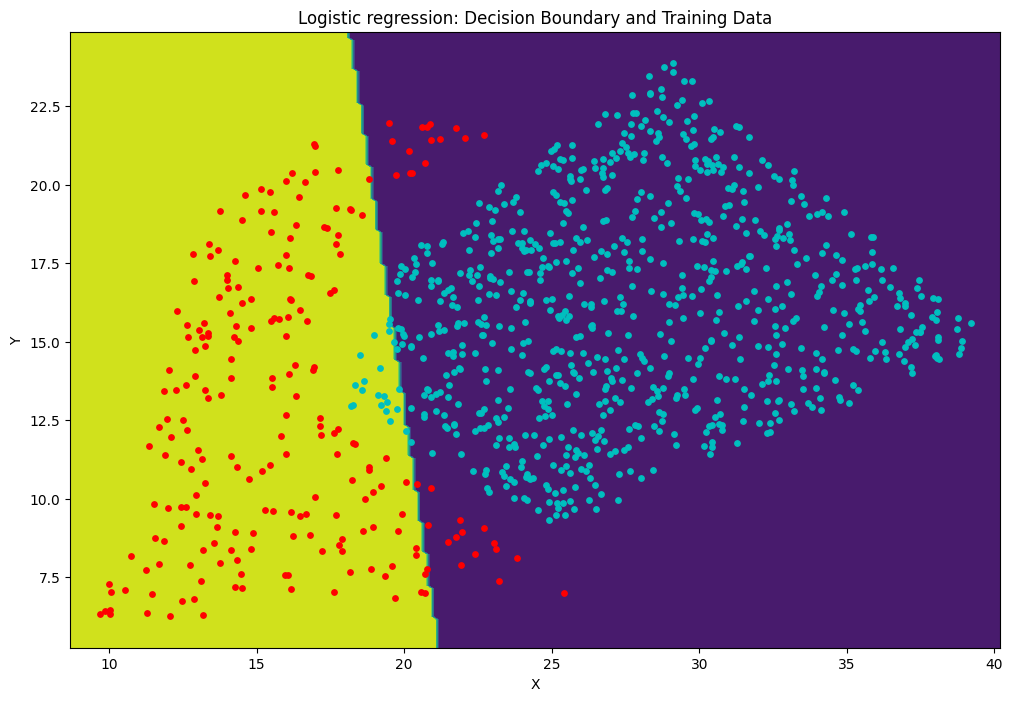

In [18]:
plt.figure(num=8, figsize=(12, 8))

lr_display = DecisionBoundaryDisplay.from_estimator(
    lr_gscv.best_estimator_, X, response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Logistic regression: Decision Boundary and Training Data')
plt.xlabel('X'); plt.ylabel('Y')

plt.scatter(data_cls_1[:, 0], data_cls_1[:, 1], s=15., c='c', label = 'Class 1')
plt.scatter(data_cls_2[:, 0], data_cls_2[:, 1], s=15., c='r', label = 'Class 2')

plt.show()

## Measuring the score

From the documentation of sklearn, we get to know that the models being plotted above are refitted entirely on the data provied to `GridSearchCV`. But this will often give use extremely overfitted models. Since the model is trained so heavily on training data, it performs very well (accuracy close to 1) on training set, but might often fail on the new / unseen data points.


Thus I will fit the models below with k-foldings and try to find the best model by looking at the confusion matrix!

In [19]:
def precision(conf_mat):
    return conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[1, 0])

def recall(conf_mat):
    return conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])

def specificity(conf_mat):
    return conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])

def fmeasure(conf_mat):
    p = precision(conf_mat)
    r = recall(conf_mat)
    return 2 * p * r / (p + r)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS+1)

In [21]:
best_dtc = DecisionTreeClassifier(**dtc_gscv.best_params_, random_state=RS)

best_dtc.fit(X_train, y_train)

dtc_cm = confusion_matrix(y_test, best_dtc.predict(X_test))

dtc_cm

array([[193,   1],
       [  1,  62]], dtype=int64)

In [22]:
best_rfc = RandomForestClassifier(**rfc_gscv.best_params_, random_state=RS)

best_rfc.fit(X_train, y_train)

rfc_cm = confusion_matrix(y_test, best_rfc.predict(X_test))

rfc_cm

array([[193,   1],
       [  2,  61]], dtype=int64)

In [23]:
best_knc = KNeighborsClassifier(**knc_gscv.best_params_)

best_knc.fit(X_train, y_train)

knc_cm = confusion_matrix(y_test, best_knc.predict(X_test))

knc_cm

array([[194,   0],
       [  0,  63]], dtype=int64)

In [24]:
best_lr = LogisticRegression(**lr_gscv.best_params_, random_state=RS)

best_lr.fit(X_train, y_train)

lr_cm = confusion_matrix(y_test, best_lr.predict(X_test))

lr_cm

array([[185,   9],
       [  7,  56]], dtype=int64)

In [25]:
import pandas as pd

pd.DataFrame({
    'Decision Tree'         : [precision(dtc_cm), recall(dtc_cm), specificity(dtc_cm), fmeasure(dtc_cm)],
    'Random Forest'         : [precision(rfc_cm), recall(rfc_cm), specificity(rfc_cm), fmeasure(rfc_cm)],
    'KNN'                   : [precision(knc_cm), recall(knc_cm), specificity(knc_cm), fmeasure(knc_cm)],
    'Logistic Regression'   : [precision( lr_cm), recall( lr_cm), specificity( lr_cm), fmeasure( lr_cm)],
}, index=['Precision', 'Recall', 'Specificity', 'F-measure']).T

,Precision,Recall,Specificity,F-measure
Decision Tree,0.994845,0.994845,0.984127,0.994845
Random Forest,0.989744,0.994845,0.968254,0.992288
KNN,1.000000,1.000000,1.000000,1.000000
Logistic Regression,0.963542,0.953608,0.888889,0.958549


We infer that KNN performs the best for the given dataset.

## Predicting the test points (#1)

Now we will use the best classifier, i.e., KNN to classify the test points.

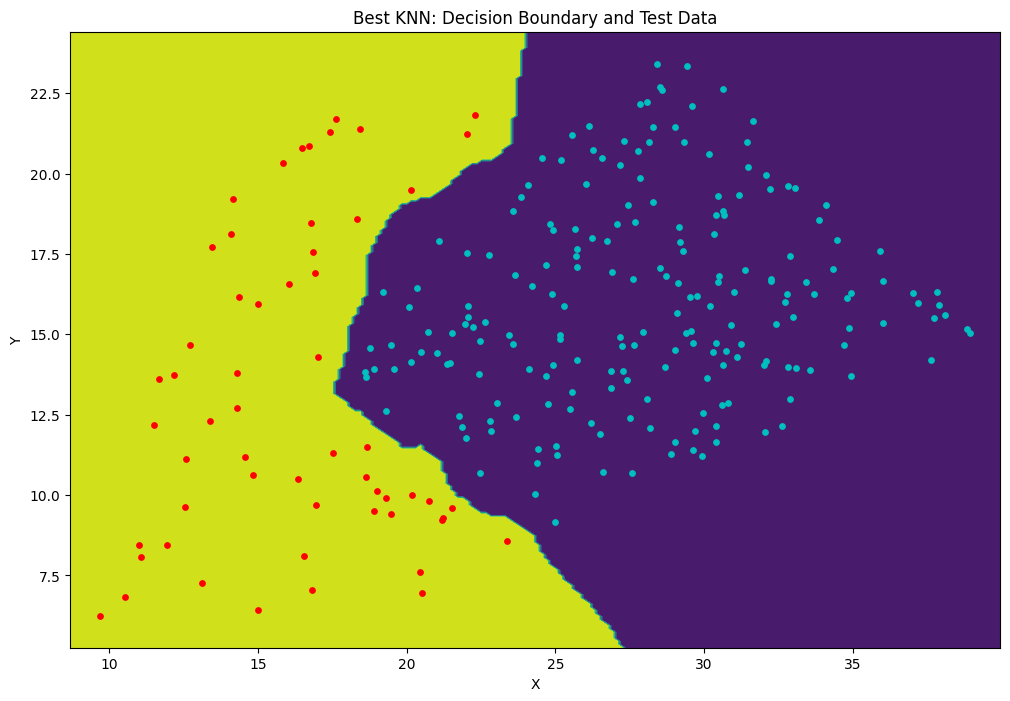

In [26]:
plt.figure(num=9, figsize=(12, 8))

knc_display = DecisionBoundaryDisplay.from_estimator(
    best_knc, UNLABELED_DATA, response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Best KNN: Decision Boundary and Test Data')
plt.xlabel('X'); plt.ylabel('Y')

y_hat = best_knc.predict(UNLABELED_DATA)

plt.scatter(*UNLABELED_DATA[y_hat==CLS1].T, s=15., c='c', label = 'Class 1')
plt.scatter(*UNLABELED_DATA[y_hat==CLS2].T, s=15., c='r', label = 'Class 2')

plt.show()

In [27]:
np.savetxt('question2.txt', y_hat, fmt='%d', header='label', comments='')

## Feature transformation

We transform a feature [x, y] to [(x - s * (y - m))^2, y] where m = 12.5 and s = .15

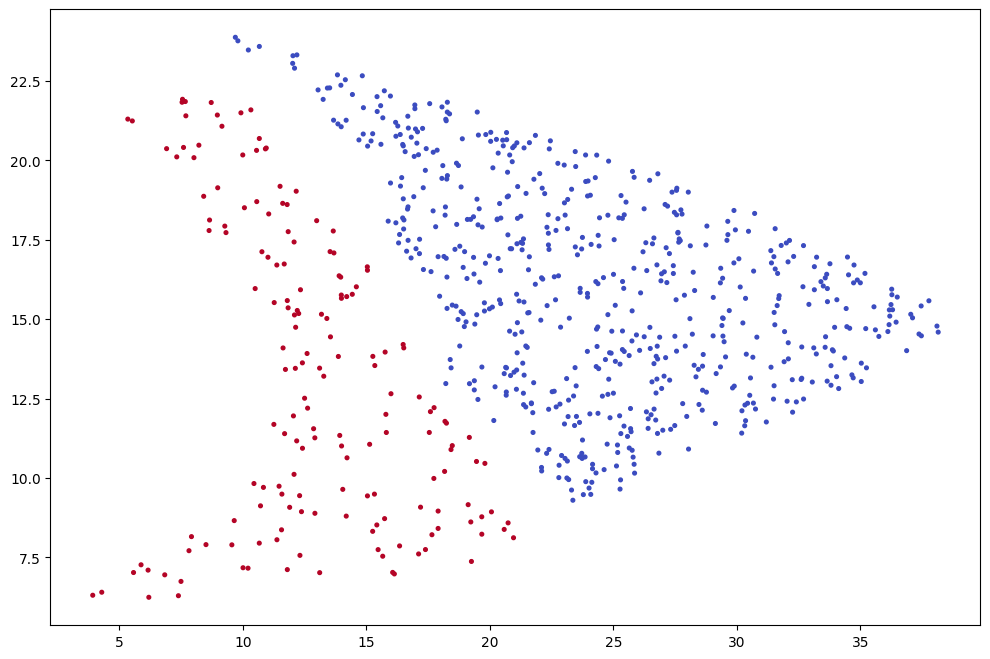

In [28]:
plt.figure(num=10, figsize=(12, 8))

m = 12.5
s = .15

def f(x, y):
    return x - s * (y - m) ** 2, y

dx, dy = f(X_train[:, 0], X_train[:, 1])

plt.scatter(dx, dy, s=7., cmap='coolwarm', c=y_train)

plt.show()

Notice we get a straight boundary now :o

Before using the best model, found before, I will first want to check how LogReg performs on this new transformed feature set.

In [29]:
lr = LogisticRegression()

dX = list(zip(dx, dy))

lr.fit(dX, y_train)

LogisticRegression()

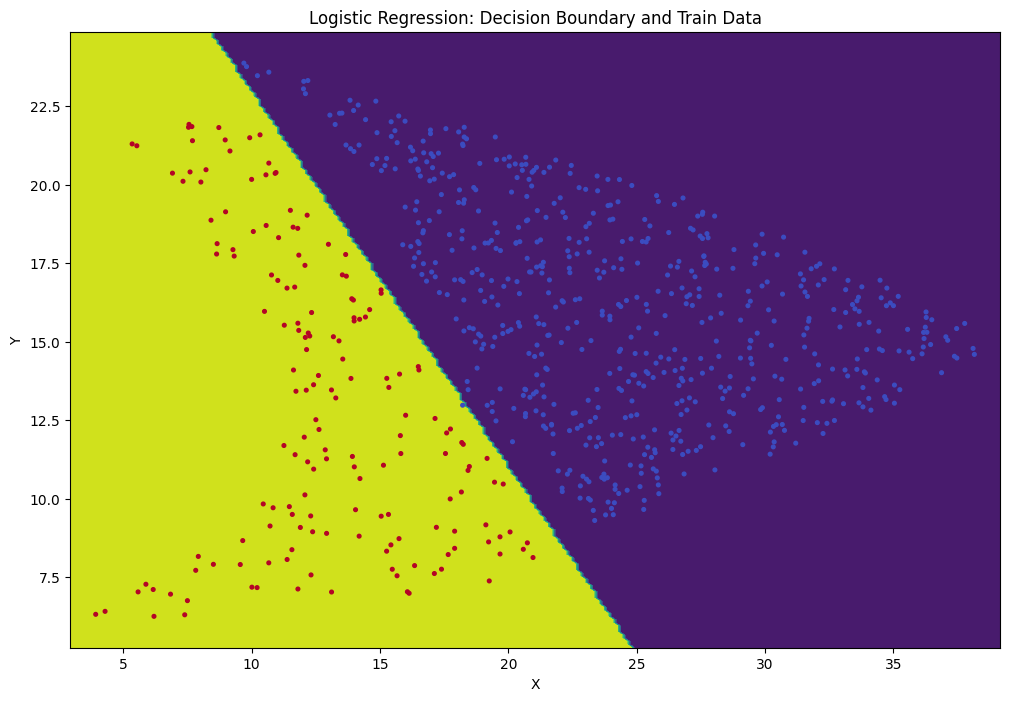

In [30]:
plt.figure(num=11, figsize=(12, 8))

lr_display = DecisionBoundaryDisplay.from_estimator(
    lr, np.array(dX), response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Logistic Regression: Decision Boundary and Train Data')
plt.xlabel('X'); plt.ylabel('Y')

plt.scatter(dx, dy, s=7., cmap='coolwarm', c=y_train)

plt.show()

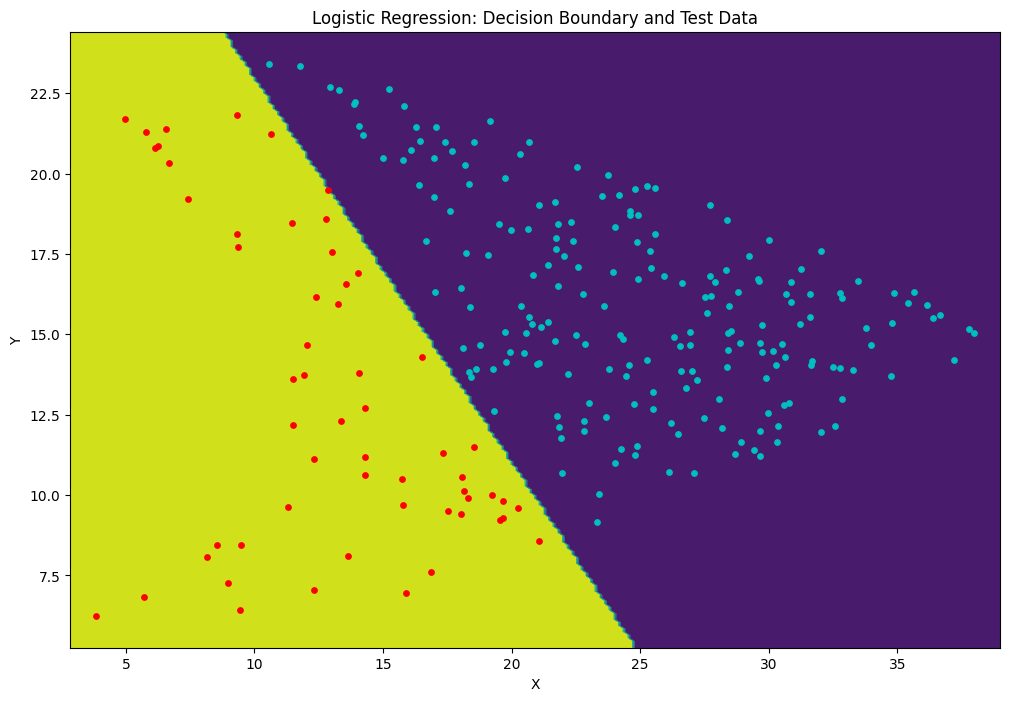

In [31]:
plt.figure(num=12, figsize=(12, 8))

D_UNLABELED_DATA = np.array(list(zip(*f(UNLABELED_DATA[:, 0], UNLABELED_DATA[:, 1]))))

lr_display = DecisionBoundaryDisplay.from_estimator(
    lr, D_UNLABELED_DATA, response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Logistic Regression: Decision Boundary and Test Data')
plt.xlabel('X'); plt.ylabel('Y')

y_hat1 = lr.predict(D_UNLABELED_DATA)

plt.scatter(*D_UNLABELED_DATA[y_hat==CLS1].T, s=15., c='c', label = 'Class 1')
plt.scatter(*D_UNLABELED_DATA[y_hat==CLS2].T, s=15., c='r', label = 'Class 2')

plt.show()

In [32]:
np.count_nonzero(y_hat-y_hat1)

0

Are new LR model give exactly the same result on test set as previous KNN gave before. This couldn't have been possible before since the boundary was not linear then.

Now we use th best KNN as the model to pridict this new feature set.

In [33]:
best_knc.fit(dX, y_train)

confusion_matrix(y_test, best_knc.predict(
    np.array(f(X_test[:, 0], X_test[:, 1])).T
))

array([[194,   0],
       [  0,  63]], dtype=int64)

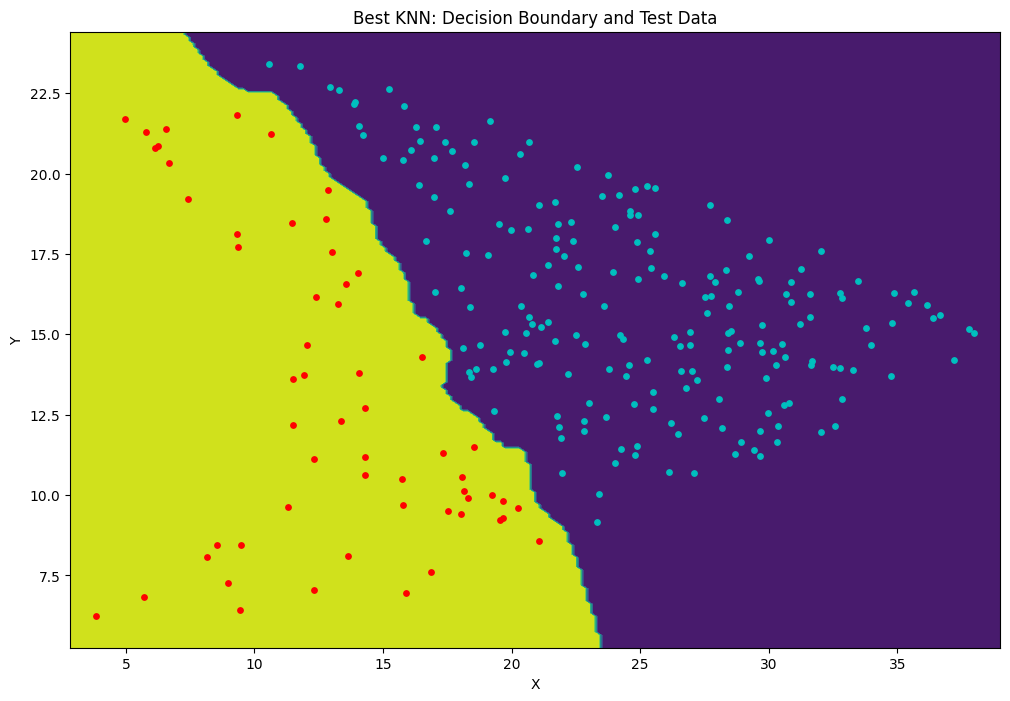

In [34]:
plt.figure(num=8, figsize=(12, 8))

knc_display = DecisionBoundaryDisplay.from_estimator(
    best_knc, D_UNLABELED_DATA, response_method='predict',
    grid_resolution = 200, ax = plt.gca()
)

plt.title('Best KNN: Decision Boundary and Test Data')
plt.xlabel('X'); plt.ylabel('Y')

y_hat1 = lr.predict(D_UNLABELED_DATA)

plt.scatter(*D_UNLABELED_DATA[y_hat==CLS1].T, s=15., c='c', label = 'Class 1')
plt.scatter(*D_UNLABELED_DATA[y_hat==CLS2].T, s=15., c='r', label = 'Class 2')

plt.show()

In [35]:
np.savetxt('question4.txt', y_hat1, fmt='%d', header='label', comments='')